In [1]:
import sys
sys.path.append("../../")
DATA_PATH = "../../data/"
SAVE_PATH = "../../plots"

import abm_py as abm
import matplotlib.pyplot as plt
import numpy as np
import py_common.utility as utility
from py_common.units import *

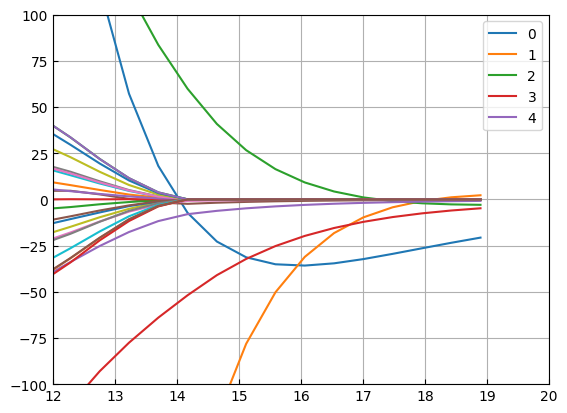

In [47]:
data = utility.load(f"{DATA_PATH}/SrF_Rb_triplet_dec.dat")
distances = data[:, 0]
values_legendre = data[:, 1:]

fig, ax = utility.plot()
ax.plot(distances, values_legendre / CMINV)
ax.legend([str(i) for i in range(5)])

ax.set_xlim(12, 20)
ax.set_ylim(-100, 100);

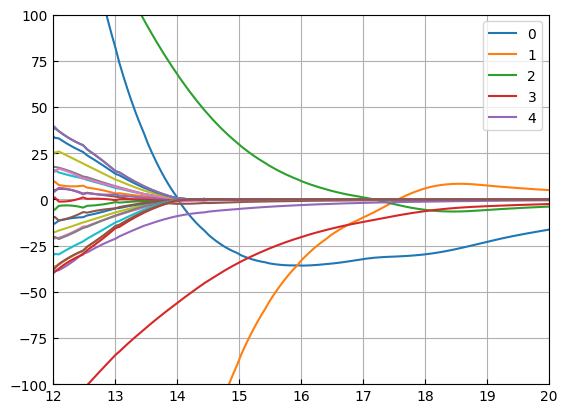

In [48]:
data = utility.load(f"{DATA_PATH}/SrF_Rb_triplet_dec_interpolated.dat")
distances = data[:, 0]
values_legendre = data[:, 1:]

fig, ax = utility.plot()
ax.plot(distances, values_legendre / CMINV)
ax.legend([str(i) for i in range(5)])

ax.set_xlim(12, 20)
ax.set_ylim(-100, 100);

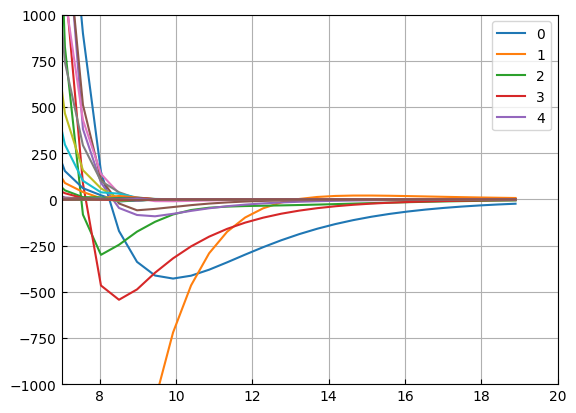

In [75]:
data = utility.load(f"{DATA_PATH}/SrF_Rb_singlet_dec.dat")
distances = data[:, 0]
values_legendre = data[:, 1:]

fig, ax = utility.plot()
ax.plot(distances, values_legendre / CMINV)
ax.legend([str(i) for i in range(5)])

ax.set_xlim(7, 20)
ax.set_ylim(-1000, 1000);

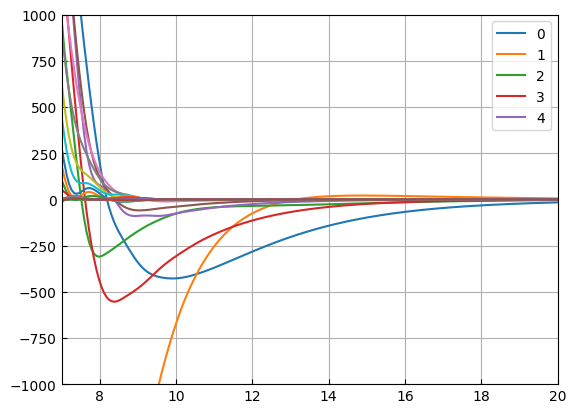

In [74]:
data = utility.load(f"{DATA_PATH}/SrF_Rb_singlet_dec_interpolated.dat")
distances = data[:, 0]
values_legendre = data[:, 1:]

fig, ax = utility.plot()
ax.plot(distances, values_legendre / CMINV)
ax.legend([str(i) for i in range(5)])

ax.set_xlim(7, 20)
ax.set_ylim(-1000, 1000);